MNIST Tutorial

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Try the next lines. If not working, download the data and extract them in the working directory.

In [3]:
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

In [5]:
mnist = read_data_sets("data", one_hot=True, reshape=False, validation_size=0)
print(mnist.train.images.shape)
print(mnist.train.labels.shape)
print(mnist.train.labels[0])

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
(60000, 28, 28, 1)
(60000, 10)
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


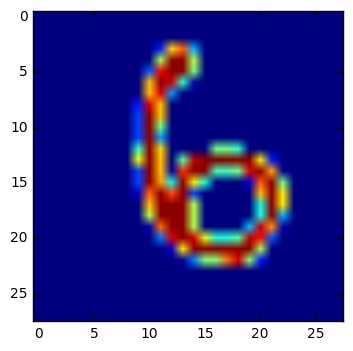

In [12]:
plt.imshow(mnist.train.images[186,:,:,:].reshape(28,28))

Compute some interesting statistics on Dataset

In [14]:
lbl, counts = np.unique(np.argmax(mnist.train.labels, axis=1), return_counts=True)
for l, c in zip(lbl, counts):
    print "{0} examples with the label {1}".format(c, l)

5923 examples with the label 0
6742 examples with the label 1
5958 examples with the label 2
6131 examples with the label 3
5842 examples with the label 4
5421 examples with the label 5
5918 examples with the label 6
6265 examples with the label 7
5851 examples with the label 8
5949 examples with the label 9


Variable Initialization

In [15]:
BLOCK = 28
N_LABELS=10
x = tf.placeholder(tf.float32, shape=[None, BLOCK, BLOCK, 1]) # For example
y = tf.placeholder(tf.float32, shape=[None, N_LABELS])
is_training = tf.placeholder(tf.bool, name="is_training")

Defining the model. try different structures and see the results:

In [28]:
from tensorflow.contrib.layers import convolution2d, flatten, fully_connected, max_pool2d, batch_norm

Classic neural network with 1 hidden layer

In [34]:
logits = flatten(x)
logits = fully_connected(logits, 10)
logits = fully_connected(logits, 10)

More hidden layers and units

In [21]:
logits = flatten(x)
logits = fully_connected(logits, 25)
logits = fully_connected(logits, 25)
logits = fully_connected(logits, 25)
logits = fully_connected(logits, 10)

With rectified linear units 

In [45]:
logits = flatten(x)
logits = fully_connected(logits, 25, activation_fn=tf.nn.relu)
logits = fully_connected(logits, 25, activation_fn=tf.nn.relu)
logits = fully_connected(logits, 25, activation_fn=tf.nn.relu)
logits = fully_connected(logits, 10)

Use convolutions to learn high level features

In [24]:
logits = convolution2d(x,  4, [5,5])
logits = max_pool2d(logits, [2,2])
logits = convolution2d(logits, 8, [5,5])
logits = max_pool2d(logits, [2,2])
logits = flatten(logits)
logits = fully_connected(logits, 200)
logits = fully_connected(logits, 10)

Use batch norm as regularisation (also speeds up optimization)

In [29]:
logits = convolution2d(x,  4, [5,5], normalizer_fn=batch_norm, normalizer_params={"is_training":is_training}, activation_fn=tf.nn.relu)
logits = max_pool2d(logits, [2,2])
logits = convolution2d(logits, 8, [4,4],normalizer_fn=batch_norm, normalizer_params={"is_training":is_training}, activation_fn=tf.nn.relu)
logits = max_pool2d(logits, [2,2])
logits = flatten(logits)
logits = fully_connected(logits, 200)
logits = fully_connected(logits, 10)

In [32]:
logits = convolution2d(x,  4, [5,5], normalizer_fn=batch_norm, normalizer_params={"is_training":is_training}, activation_fn=tf.nn.relu)
logits = convolution2d(logits,  4, [5,5], normalizer_fn=batch_norm, normalizer_params={"is_training":is_training}, activation_fn=tf.nn.relu)
logits = max_pool2d(logits, [2,2])
logits = convolution2d(logits, 8, [4,4],normalizer_fn=batch_norm, normalizer_params={"is_training":is_training}, activation_fn=tf.nn.relu)
logits = max_pool2d(logits, [2,2])
logits = flatten(logits)
logits = fully_connected(logits, 200)
logits = fully_connected(logits, 10)

Defining the loss to minimize

In [46]:
y_ = tf.nn.softmax(logits)

# Cross entropy error term
loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits, y) )*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Change the loss for the cross entropy if you want

train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [55]:
BATCH_SIZE=60
N_ITERATIONS=10000

TRAIN_PRINT=1000
TEST_PRINT=1000


index = np.arange(0, mnist.train.images.shape[0], BATCH_SIZE)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())


for idx in range(N_ITERATIONS):

    batch_X, batch_Y = mnist.train.next_batch(100)

    if not (idx % TRAIN_PRINT):
        a, c = sess.run([accuracy, loss], {x: batch_X, y: batch_Y})
        print("It {0}: Train: Accuracy: {1} Cross-entropy: {2}".format(idx, a, c))

    if not (idx % TEST_PRINT):
        a, c = sess.run([accuracy, loss], {x: mnist.test.images, y: mnist.test.labels})
        print("It {0}: Test: Accuracy: {1} Cross-entropy: {2}".format(idx, a, c))

    # Backpropagation training step
    sess.run(train_step, {x: batch_X, y: batch_Y})

It 0: Train: Accuracy: 0.0799999982119 Cross-entropy: 232.290939331
It 0: Test: Accuracy: 0.0861999988556 Cross-entropy: 231.831481934
It 1000: Train: Accuracy: 0.899999976158 Cross-entropy: 53.968120575
It 1000: Test: Accuracy: 0.789399981499 Cross-entropy: 77.4388809204
It 2000: Train: Accuracy: 0.810000002384 Cross-entropy: 61.4930267334
It 2000: Test: Accuracy: 0.811900019646 Cross-entropy: 58.6239814758
It 3000: Train: Accuracy: 0.800000011921 Cross-entropy: 52.5401954651
It 3000: Test: Accuracy: 0.821799993515 Cross-entropy: 52.7609481812
It 4000: Train: Accuracy: 0.870000004768 Cross-entropy: 38.0245018005
It 4000: Test: Accuracy: 0.828599989414 Cross-entropy: 49.6624717712
It 5000: Train: Accuracy: 0.860000014305 Cross-entropy: 43.3975105286
It 5000: Test: Accuracy: 0.834800004959 Cross-entropy: 47.3485031128
It 6000: Train: Accuracy: 0.810000002384 Cross-entropy: 60.066204071
It 6000: Test: Accuracy: 0.837700009346 Cross-entropy: 45.8685073853
It 7000: Train: Accuracy: 0.80000

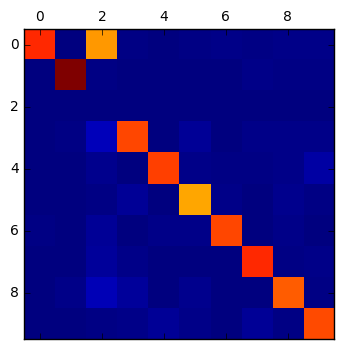

In [56]:
from sklearn.metrics import confusion_matrix

cm=np.zeros((N_LABELS, N_LABELS))

N_LIMIT=100

labels, preds = sess.run([tf.argmax(y, 1), tf.argmax(y_, 1)], {x: mnist.test.images, y: mnist.test.labels})

plt.matshow(confusion_matrix(preds, labels))


Accuracy check

In [58]:
score = 1.*(labels==preds).sum() / labels.shape[0]
print "Total score: {}".format(score)

Total score: 0.8464


# Exercices
* Fill the blanks
* Create the graph of the loss during training
* Compute training and testing performance
* What is the best structure for this dataset?
* Print the images where the net is wrong. Display using plt.imshow.
* Compare the convolutional/deep learning approach with the classic machine learning pipeline? What are the usual best classifiers? Try them and compare the results and training time.
* BONUS: Try the next dataset